In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1L5GSRbeoQeUofNI9oP_twgGBr3NLtK2k/view?usp=sharing
!unzip -q '/content/PBL Series #3 CNN - Emotion.zip'
!pip install torchinfo timm -q

Downloading...
From: https://drive.google.com/uc?id=1L5GSRbeoQeUofNI9oP_twgGBr3NLtK2k
To: /content/PBL Series #3 CNN - Emotion.zip
100% 60.7M/60.7M [00:00<00:00, 158MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.3 MB/s eta 0:00:00


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

train_dir = 'Human Emotion Classification/train'
val_dir = 'Human Emotion Classification/val'

try:
    os.makedirs(val_dir)

    for cls in os.listdir(train_dir):

        train_class_dir = os.path.join(train_dir, cls)
        val_class_dir = os.path.join(val_dir, cls)

        if not os.path.exists(val_class_dir):
            os.makedirs(val_class_dir)

        fnames = os.listdir(train_class_dir)

        train_fnames, val_fnames = train_test_split(fnames, test_size=0.2, random_state=42)

        for name in val_fnames:
            src = os.path.join(train_class_dir, name)
            dst = os.path.join(val_class_dir, name)
            shutil.move(src, dst)

except Exception as e:
    print('Already splitted')

In [ ]:
import torch
import timm

class CNN(torch.nn.Module):
    def __init__(self, model_name, num_classes, freeze_base_model=True):
        super().__init__()
        self.base_model = timm.create_model(
            model_name=model_name,
            pretrained=True,
            num_classes=num_classes)

        if freeze_base_model:
            for name, layer in self.base_model.named_children():
                if name != [i for i, _ in self.base_model.named_children()][-1]:
                    for param in layer.parameters():
                        param.requires_grad = False

    def forward(self, x):
        return self.base_model(x)

    def get_transforms(self, is_training):
        data_config = timm.data.resolve_model_data_config(self.base_model)
        return timm.data.create_transform(**data_config, is_training=is_training)

    def summary(self, input_size):
        from torchinfo import summary
        print(summary(model, input_size=input_size, col_names=("input_size","output_size", "num_params", "trainable")))

Model bisa cari di https://huggingface.co/timm

Yang tidak eksperimen data augmentasi, yang dirun ini aja yang bawahnya jangan dirun

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torchvision import models


# ================================================================
model_name = 'timm/convnextv2_tiny.fcmae_ft_in22k_in1k_384' # ganti nama modelnya, cari di https://huggingface.co/timm
freeze_base_model = False # ganti jadi True atau False
# ================================================================


model = CNN(model_name, 3, freeze_base_model)
train_transforms = model.get_transforms(True)
transforms = model.get_transforms(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = '/content/Human Emotion Classification'

train_data = ImageFolder(
    f'{data_dir}/train',
    transform=train_transforms
)

val_data = ImageFolder(
    f'{data_dir}/val',
    transform=transforms
)

test_data = ImageFolder(
    f'{data_dir}/test',
    transform=transforms
)

class_names = test_data.classes

print('augmentation: \n', train_transforms)

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

augmentation: 
 Compose(
    RandomResizedCropAndInterpolation(size=(384, 384), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


Yang mau eksperimen data augmentasi, yang dirun ini aja yang atas jangan dirun, ganti yang ada di dalem `train_transforms` kecuali yang 3 terakhir itu biarkan saja. Dokumentasi data augmentasi: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torchvision import models


# ================================================================
model_name = 'timm/convnextv2_tiny.fcmae_ft_in22k_in1k_384' # ganti nama modelnya, cari di https://huggingface.co/timm
freeze_base_model = False # ganti jadi True atau False
# ================================================================


train_transforms = v2.Compose([
    v2.Resize(size=(384, 384), interpolation=v2.InterpolationMode.BICUBIC, antialias=True), # ubah sizenya saja, size tergantung model
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4)),
    v2.RandAugment(),
    v2.ToImage(), # jangan diubah
    v2.ToDtype(torch.float32, scale=True), # jangan diubah
    v2.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250]), # jangan diubah
])

# transforms jangan diubah ubah
transforms = v2.Compose([
    v2.Resize(size=(384, 384), interpolation=v2.InterpolationMode.BICUBIC, antialias=True),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250]),
])



model = CNN(model_name, 3, freeze_base_model)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = '/content/Human Emotion Classification'

train_data = ImageFolder(
    f'{data_dir}/train',
    transform=train_transforms
)

val_data = ImageFolder(
    f'{data_dir}/val',
    transform=transforms
)

test_data = ImageFolder(
    f'{data_dir}/test',
    transform=transforms
)

class_names = test_data.classes

print('augmentation: \n', train_transforms)

augmentation: 
 Compose(
      Resize(size=[384, 384], interpolation=InterpolationMode.BICUBIC, antialias=True)
      RandomHorizontalFlip(p=0.5)
      ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4))
      RandAugment(interpolation=InterpolationMode.NEAREST, num_ops=2, magnitude=9, num_magnitude_bins=31)
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)


In [ ]:
from torch.utils.data import default_collate


# ================================================================
# batch_size coba yang antara 32 atau 64
batch_size = 32
use_cutmix_mixup = True # ganti True atau False
# ================================================================


cutmix = v2.CutMix(num_classes=len(class_names), alpha=1.0)
mixup = v2.MixUp(num_classes=len(class_names), alpha=0.2)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup], p=[0.5, 0.5])

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

if use_cutmix_mixup:
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=2,
        collate_fn=collate_fn,
        shuffle=True,
        prefetch_factor=2
    )
    print('use cutmix mixup')
else:
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True,
        prefetch_factor=2
    )

val_dataloader = DataLoader(
    val_data,
    batch_size=batch_size,
    num_workers=2,
    prefetch_factor=2
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=2
)

In [ ]:
import os
import torch

from torch.cuda.amp import GradScaler
from typing import Dict
from tqdm.notebook import tqdm

scaler = GradScaler()
def train_step(model, data_loader, loss_fn, optimizer, device, use_amp=False):
    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0

    data_loader_iter = tqdm(enumerate(data_loader), desc="Training", unit="step", total=len(data_loader))

    for batch, (X, y) in data_loader_iter:
        X, y = X.to(device), y.to(device)

        if use_amp:
            with torch.autocast(device_type=device, dtype=torch.float16):
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        else:
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            loss.backward()
            optimizer.step()

        train_loss += loss.item()
        optimizer.zero_grad(set_to_none=True)

        data_loader_iter.set_postfix({"Train Loss": f"{train_loss / (batch + 1):.4f}"})

    train_loss /= len(data_loader)

    return train_loss, train_acc

def val_step(model, data_loader, loss_fn, device):
    model.to(device)
    model.eval()

    val_loss, val_acc = 0, 0

    data_loader_iter = tqdm(enumerate(data_loader), desc="Validation", unit="step", total=len(data_loader))

    with torch.inference_mode():
        for batch, (X_val, y_val) in data_loader_iter:
            X_val, y_val = X_val.to(device), y_val.to(device)

            val_pred = model(X_val)

            loss = loss_fn(val_pred, y_val)
            val_loss += float(loss)

            val_pred_class = val_pred.argmax(dim=1)
            acc = (val_pred_class == y_val).sum().item() / len(val_pred_class)
            val_acc += acc

            data_loader_iter.set_postfix({"Val Loss": f"{val_loss / (batch + 1):.4f}", "Val Acc": f"{val_acc / (batch + 1):.4f}"})

    val_loss /= len(data_loader)
    val_acc /= len(data_loader)

    return val_loss, val_acc

def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, scheduler, epochs, device, use_amp=False, progress=True) -> Dict[str, list]:
    os.makedirs('/models', exist_ok=True)
    result = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    for epoch in range(epochs):
        print(f"Epoch: {epoch+1} | lr: {scheduler.get_last_lr()}")
        result['lr'].append(scheduler.get_last_lr())
        train_loss, train_acc = train_step(
            model,
            train_dataloader,
            loss_fn,
            optimizer,
            device,
            use_amp
        )

        result['train_loss'].append(float(train_loss))

        val_loss, val_acc = val_step(
            model,
            val_dataloader,
            loss_fn,
            device
        )

        result['val_loss'].append(float(val_loss))
        result['val_acc'].append(val_acc)


        scheduler.step()
        torch.save(model.state_dict(), f'/models/model-{epoch}.pth')
    return result

In [ ]:
import torch
import timm
from torch import nn

# ================================================================
nama = '' # nama kalian
epochs = 15 # epochs antara 5 - 25
lr = 0.00001 # lr < 0.0009
# ================================================================

model = CNN(model_name, len(class_names), freeze_base_model)

param_groups = []
decay = []
no_decay = []

for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if len(param.shape) == 1 or name.endswith(".bias"):
        no_decay.append(param)
    else:
        decay.append(param)

param_groups.append({"params": no_decay, "weight_decay": 0.0})
param_groups.append({"params": decay, "weight_decay": 0.001})


optimizer = torch.optim.AdamW(param_groups, lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss_fn = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

result = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scheduler=scheduler,
    epochs=epochs,
    use_amp=True,
    device=device
)

Epoch: 1 | lr: [2.5e-05, 2.5e-05]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 2 | lr: [2.4726845009172572e-05, 2.4726845009172572e-05]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 3 | lr: [2.391931822053251e-05, 2.391931822053251e-05]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 4 | lr: [2.2612712429686845e-05, 2.2612712429686845e-05]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 5 | lr: [2.086413257948573e-05, 2.086413257948573e-05]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 6 | lr: [1.8750000000000002e-05, 1.8750000000000002e-05]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 7 | lr: [1.6362712429686846e-05, 1.6362712429686846e-05]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 8 | lr: [1.3806605790845672e-05, 1.3806605790845672e-05]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 9 | lr: [1.1193394209154336e-05, 1.1193394209154336e-05]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 10 | lr: [8.63728757031316e-06, 8.63728757031316e-06]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 11 | lr: [6.2500000000000045e-06, 6.2500000000000045e-06]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 12 | lr: [4.135867420514277e-06, 4.135867420514277e-06]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 13 | lr: [2.3872875703131587e-06, 2.3872875703131587e-06]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 14 | lr: [1.080681779467488e-06, 1.080681779467488e-06]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Epoch: 15 | lr: [2.73154990827429e-07, 2.73154990827429e-07]


Training:   0%|          | 0/57 [00:00<?, ?step/s]

Validation:   0%|          | 0/15 [00:00<?, ?step/s]

Plot

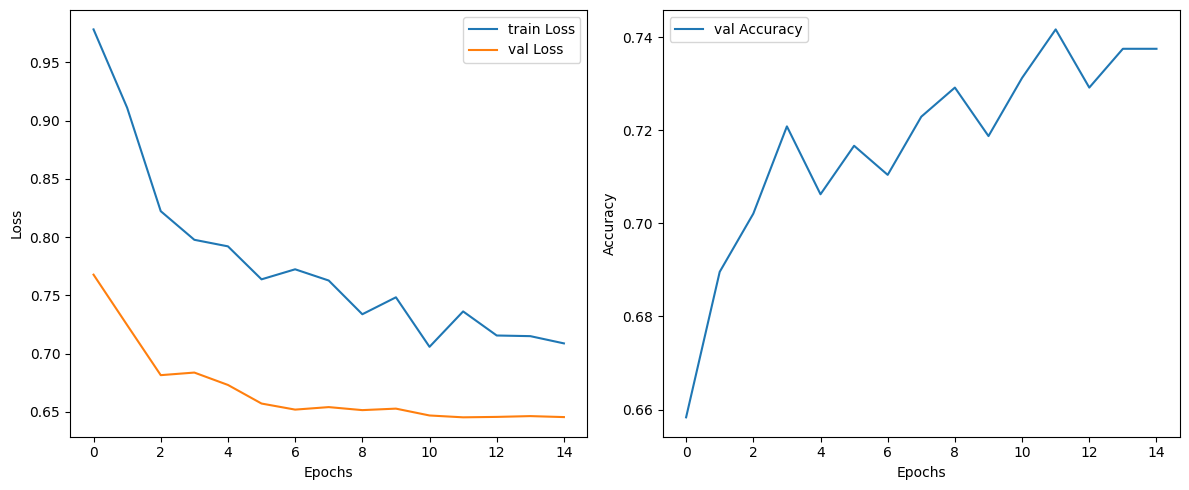

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(result["train_loss"], label="train Loss")
axs[0].plot(result["val_loss"], label="val Loss")
axs[0].legend()
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(result["val_acc"], label="val Accuracy")
axs[1].legend()
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

best_model = np.argmax(np.array(result['val_acc']), axis=0)
model.load_state_dict(torch.load(f'/models/model-{best_model}.pth'))

model.to(device)
all_labels = []
all_predictions = []

with torch.inference_mode():
    for data, label in tqdm(test_dataloader):
        data, label = data.to(device), label.to(device)
        logits = model(data)

        predictions = logits.argmax(1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(label.cpu().numpy())

f1 = f1_score(all_labels, all_predictions, average='weighted')
acc = accuracy_score(all_labels, all_predictions)
print(f"F1 Score: {f1} | Accuracy: {acc}")

  0%|          | 0/18 [00:00<?, ?it/s]

F1 Score: 0.7308716233711408 | Accuracy: 0.7293497363796133


In [ ]:
import os
from huggingface_hub import login, HfApi
import pandas as pd
import uuid
from pathlib import Path

# ================================================================
hf_token = '' # token hf bisa dicek di https://huggingface.co/settings/tokens
# ================================================================


model_name = model_name.split('/')[-1]
login(hf_token, add_to_git_credential=True)
model.load_state_dict(torch.load(f'/models/model-{best_model}.pth'))
exp_dir = Path('experiment/experiment')
os.makedirs(exp_dir, exist_ok=True)
os.makedirs(exp_dir / 'models', exist_ok=True)
torch.save(model.state_dict(), f'/content/experiment/experiment/models/{nama}-{model_name}-{best_model+1}-{f1:4f}.pth')
experiment_config = {
    'nama': nama,
    'model_name': model_name,
    'freeze_base_model': freeze_base_model,
    'data_augmentation': [' | '.join([str(transform) for transform in train_transforms.transforms])],
    'cutmix_mixup': use_cutmix_mixup,
    'batch_size': batch_size,
    'epochs': epochs,
    'optimizer': optimizer.__class__.__name__,
    'learning_rate': lr,
    'lr_scheduler': scheduler.__class__.__name__,
    'train_loss': result['train_loss'][best_model],
    'val_loss': result['val_loss'][best_model],
    'val_accuracy': result['val_acc'][best_model],
    'test_accuracy': acc,
    'f1_score': f1,
    'best_at_epoch': best_model+1,
    'checkpoint': f'models/{nama}-{model_name}-{best_model+1}-{f1:4f}.pth'
}

df = pd.DataFrame(experiment_config)
df.to_csv(exp_dir / f'{nama}-{model_name}-{best_model+1}-{f1:4f}.csv')

api = HfApi()
api.upload_folder(
    folder_path='experiment',
    repo_id="JST4/experiment-project-3-cnn",
    repo_type="dataset",
)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Taufiq-convnextv2_tiny.fcmae_ft_in22k_in1k_384-12-0.730872.pth:   0%|          | 0.00/112M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/JST4/experiment-project-3-cnn/commit/1f0757927a8c8dd9da4d86cf275a316054f4ea79', commit_message='Upload folder using huggingface_hub', commit_description='', oid='1f0757927a8c8dd9da4d86cf275a316054f4ea79', pr_url=None, pr_revision=None, pr_num=None)